In [0]:
!pip install mxnet==1.4.1
!pip install gluonts

In [0]:
"""
DO NOT RUN THIS CELL UNLESS YOU WANT TO IMPORT THE R_Forecast MODULE FROM GLUONTS
"""
!pip install 'rpy2>=2.9.*,<3.*'
!R -e 'install.packages(c("forecast", "nnfor"), repos="https://cloud.r-project.org")'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from itertools import islice
from pathlib import Path
from gluonts.dataset.artificial._base import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.dataset.field_names import FieldName

from gluonts.model.deepstate import DeepStateEstimator
from gluonts.model.deepar import DeepAREstimator

from gluonts.trainer import Trainer
from gluonts.model.predictor import Predictor
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from scipy.stats import boxcox

INFO:root:Using CPU
INFO:root:Using CPU


# Implementation of the LDS/Kalman Filter


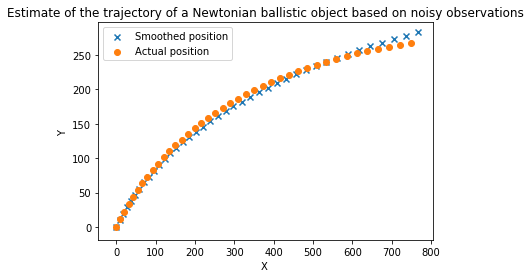

In [5]:
"""
Implementation of LDS Forward and Backward Pass 

Note that everything here will be a matrix including vectors like
v_t and h_t. 

(Refer to Bayesian Reasoning and Machine Learning for notation)

"""
np.random.seed(10)

def Update(f, F, v, A, B, Sigma_h, Sigma_v, meanH, meanV):
    mu_h = np.matmul(A,f) + meanH
    mu_v = np.matmul(B,mu_h) + meanV
    Sigma_hh = np.matmul(np.matmul(A, F), A.T) + Sigma_h
    Sigma_vv = np.matmul(np.matmul(B, Sigma_hh), B.T) + Sigma_v
    Sigma_vh = np.matmul(B, Sigma_hh)
    f_prime = mu_h + np.matmul(np.matmul(Sigma_vh.T, np.linalg.inv(Sigma_vv)), v - mu_v)
    F_prime = Sigma_hh - np.matmul(np.matmul(Sigma_vh.T, np.linalg.inv(Sigma_vv)), Sigma_vh)
    p_prime = np.exp(-0.5*np.matmul((v-mu_v).T, np.matmul(np.linalg.inv(Sigma_vv), (v-mu_v)))) /np.sqrt(np.linalg.det(2*np.pi*Sigma_vv))
    return (f_prime,  F_prime, p_prime)

def Forward(v, A, B, Sigma_h, Sigma_v, meanH, meanV, Sigma_P, meanP):
    # initialize
    H = B.shape[1]
    T = v.shape[0]
    f = np.zeros((T,H))
    F = np.zeros((T, H, H))
    logpv = np.zeros(T)
    
    result = Update(np.zeros(H),np.zeros((H,H)),v[0], A, B, Sigma_P, Sigma_v, meanP, meanV)
    f[0], F[0], logpv[0] =  result[0], result[1], result[2]
    
    for t in range(1, T):
        f[t], F[t], logpv[t] = Update(f[t-1], F[t-1], v[t], A, B, Sigma_h, Sigma_v, meanH, meanV)

    L = np.sum(logpv)
    return f, F, L

def BackwardUpdate(g, G, f, F, A, Sigma_h, meanH):
    mu_h = np.matmul(A, f) + meanH
    Shtptp = np.matmul(np.matmul(A, F), A.T) + Sigma_h
    Shtpt = np.matmul(A, F)
    leftA = np.matmul(Shtpt.T, np.linalg.inv(Shtptp))
    leftS = F - np.matmul(leftA, Shtpt)
    leftm = f - np.matmul(leftA, mu_h)
    gnew = np.matmul(leftA, g) + leftm
    Gnew = np.matmul(np.matmul(leftA, G), leftA.T) + leftS; 
    Gnew = 0.5*(Gnew + Gnew.T)
    return gnew, Gnew

def Backward(v, A, B, f, F, Sigma_h, meanH):
    T = v.shape[0]
    H = B.shape[1]
    g = np.zeros((T, H))
    G = np.zeros((T, H, H))
    g[T-1] = f[T-1]
    G[T-1] = F[T-1]
    for t in range(T-2, -1,-1):
        g[t], G[t] = BackwardUpdate(g[t+1],G[t+1],f[t],F[t], A, Sigma_h, meanH)
    return g, G

def Smooth(v, A, B, Sigma_h, Sigma_v, CovP, meanP, meanH, meanV):
    f2, F2, loglik = Forward(v, A, B, Sigma_h, Sigma_v, meanH, meanV, CovP, meanP)
    g2, G2 = Backward(v, A, B, f2, F2, CovH, meanH)
    V, T = v.shape 
    H = CovH.shape[0]
    f=f2 
    F=F2 
    g=g2
    G=G2 
    return f, F, g, G, loglik



# Newtonian Trajectory Analysis Example from the book.
T = 400  # number of timesteps
Delta = 0.1 # discretisation of time
# Hidden Variables are (in order) : xp,x,yp,y,fxom,fyom
# xp : x speed
# x : x position
# yp : y speed
# y : y position
# fxom : x acceleration
# fyom : y acceleration

# Newtonian Dynamics for Transitions:
A = np.zeros((6, 6))
A[0,:] = [1,0,0,0,Delta,0]
A[1,:] = [Delta,1,0,0,0,0]
A[2,:] = [0,0,1,0,0,Delta]
A[3,:] = [0,0,Delta,1,0,0]
A[4,:] = [0,0,0,0,1,0]
A[5,:] = [0,0,0,0,0,1]


# Observations are positions x and y
B = np.zeros((2, 6))
B[0,:] = [0,1,0,0,0,0]
B[1,:] = [0,0,0,1,0,0]

# Generate some Data:
h = np.zeros((T,6))

# initial x and y position
h[0,1] = np.random.rand() 
h[0,3] = np.random.rand()

# initial x and y velocity
h[0,0] = 15 * np.random.rand()
h[0,2] = 15 * np.random.rand()

# initial x and y accelerations
h[0,4] = np.random.rand()
h[0,5] = -np.random.rand()

# emission noise (standard deviation) same for both x and y
sigV = 50  
sigH = 0.00001 # small transition noise

v = np.zeros((T, 2))
v[0] = np.matmul(B, h[0]) + sigV * np.random.randn(2)

for t in range(1, T):
    h[t] = np.matmul(A, h[t-1]) + sigH * np.random.randn(6)  # Noisy Newtonian Dynamics  
    v[t] = np.matmul(B, h[t]) + sigV * np.random.randn(2)    # Noisy observation



# Setup the LDS
CovH = sigH * sigH * np.eye(6, dtype = float) # transition noise
CovV = sigV * sigV * np.eye(2, dtype = float) # emission noise

# initialize some prior
CovP = np.eye(6, dtype = float) 
meanP = np.zeros(6) 

# initial the mean for the noise
meanH = np.zeros(6)
meanV = np.zeros(2)

#Trajectory Estimates:

dum1, dum2, mean_post, cov_post, dum3 = Smooth(v, A, B, CovH, CovV, CovP, meanP, meanH, meanV)

# plot every 10th timestep
kalman_x = [mean_post[i, 1] for i in range(0, T, 10)]
kalman_y = [mean_post[i, 3] for i in range(0, T, 10)]

actual_x = [h[i, 1] for i in range(0, T, 10)]
actual_y = [h[i, 3] for i in range(0, T, 10)]

plt.title("Estimate of the trajectory of a Newtonian ballistic object based on noisy observations")
plt.scatter(kalman_x, kalman_y, label="Smoothed position", marker="x")
plt.scatter(actual_x, actual_y, label="Actual position",marker="o")
path = "./drive/My Drive/CSE303/KalmanPlot.png"
plt.savefig(path, bbox_inches='tight')
plt.xlabel("X ")
plt.ylabel("Y ")
plt.legend()
plt.show()


# Initial Setup:


1.   Generate Custom Data Set.
2.   Visualize the time series.
3.   Plot the probabilistic forecast obtained from the algorithm.



In [0]:
def create_dataset(num_series, num_steps, period=24, mu=1, sigma=10):
    # create target: noise + pattern    
    # noise
    noise = np.random.normal(mu, sigma, size=(num_series, num_steps))
    
    # pattern - sinusoid with different phase
    sin_minumPi_Pi = np.sin(np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period)))
    sin_Zero_2Pi = np.sin(np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period)))
    
    pattern = np.concatenate((np.tile(sin_minumPi_Pi.reshape(1, -1), 
                                      (int(np.ceil(num_series / 2)),1)), 
                              np.tile(sin_Zero_2Pi.reshape(1, -1), 
                                      (int(np.floor(num_series / 2)), 1))
                             ),axis=0
                            )
    
    target = noise + pattern
    
    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate((np.zeros((num_series, period)), 
                                        target[:, :-period]
                                       ), 
                                       axis=1
                                      )
    
    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.concatenate((np.zeros(int(np.ceil(num_series / 2))), 
                                      np.ones(int(np.floor(num_series / 2)))
                                     ),
                                     axis=0
                                    )
    
    return target, feat_dynamic_real, feat_static_cat
    
def make_plot(train_entry, test_entry):
	test_series = to_pandas(test_entry)
	train_series = to_pandas(train_entry)

	fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

	train_series.plot(ax=ax[0])
	ax[0].grid(which="both")
	ax[0].legend(["train series"], loc="upper left")

	test_series.plot(ax=ax[1])
	ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
	ax[1].grid(which="both")
	ax[1].legend(["test series", "end of train series"], loc="upper left")	
	plt.savefig("first-train-test-plot.png")
	
def plot_prob_forecasts(ts_entry, forecast_entry, path, option=""):
    plot_length = 150 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] +\
		 [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.title(option)
    plt.legend(legend, loc="upper left")
    plt.savefig(os.path.join(path,'plot_prob_forecast.png'))
    plt.show()
    


"""
ts_first = tss[0]
forecast_first = forecast[0] # contain sample paths with dimension (num_samples, prediction_length)
plot_prob_forecasts(ts_first, forecast_first,"./")
"""


'\nts_first = tss[0]\nforecast_first = forecast[0] # contain sample paths with dimension (num_samples, prediction_length)\nplot_prob_forecasts(ts_first, forecast_first,"./")\n'

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


(5, 240)
(5, 240)
(5,)


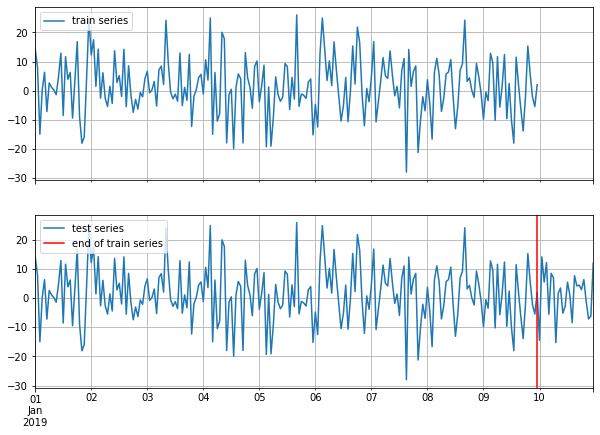

In [0]:
mx.random.seed(10)
np.random.seed(10)

# define the parameters of the dataset
custom_ds_metadata = {'num_series': 5,
                      'num_steps': 24 * 10,
                      'prediction_length': 24,
                      'freq': '1H',
                      'start': [pd.Timestamp("01-01-2019", freq='1H') 
                                for _ in range(10)]
                     }
                     
data_out = create_dataset(custom_ds_metadata['num_series'], 
                          custom_ds_metadata['num_steps'],
                          custom_ds_metadata['prediction_length']
                         )
                     
target, feat_dynamic_real, feat_static_cat = data_out

print(target.shape)
print(feat_dynamic_real.shape)
print(feat_static_cat.shape)

train_ds = ListDataset([{FieldName.TARGET: target, 
                         FieldName.START: start,
                         FieldName.FEAT_DYNAMIC_REAL: fdr,
                         FieldName.FEAT_STATIC_CAT: fsc} 
                        for (target, start, fdr, fsc) in zip(target[:, :-custom_ds_metadata['prediction_length']], 
                                                             custom_ds_metadata['start'], 
                                                             feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']], 
                                                             feat_static_cat)], freq=custom_ds_metadata['freq'])
                      
test_ds = ListDataset([{FieldName.TARGET: target, 
                        FieldName.START: start,
                        FieldName.FEAT_DYNAMIC_REAL: fdr,
                        FieldName.FEAT_STATIC_CAT: fsc} 
                       for (target, start, fdr, fsc) in zip(target, 
                                                            custom_ds_metadata['start'], 
                                                            feat_dynamic_real, 
                                                            feat_static_cat)],
                     freq=custom_ds_metadata['freq'])

# first time series in the train and test dataset
train_entry = next(iter(train_ds))
test_entry = next(iter(test_ds))

make_plot(train_entry, test_entry)	

# Experiment 1:

Varying the number of layers of the RNN.



In [0]:
"""
Step 2: Train the existing Deepstate Model with different parameters for the RNN
"""

def run_exp_layers(num_layers_list): 
    
    for i in num_layers_list:
        print ("Num of Layers = ", i)
        estimator = DeepStateEstimator(
                    prediction_length=custom_ds_metadata['prediction_length'],
                    freq=custom_ds_metadata['freq'],
                    num_layers=i,
                    trainer=Trainer(ctx="cpu", 
                            epochs=50, 
                            learning_rate=1e-3, 
                            hybridize=False, 
                            num_batches_per_epoch=10
                                ),
                    use_feat_static_cat=False,
                    cardinality=[1]
                )
        # Train model on the training dataset
        predictor = estimator.train(train_ds)
        print ("Training done!")
        # Save the model
        path = "./drive/My Drive/num_layer_{}".format(i)
        if not os.path.isdir(path):
            os.makedirs(path)
        predictor.serialize(Path(path))
        print ("Network Serialized!")
        # forecast using the model
        forecast_it, ts_it = make_evaluation_predictions(
                dataset=test_ds,  # test dataset
                predictor=predictor,  # predictor
                num_samples=100,  # number of sample paths we want for evaluation
                )
        print ("Forecasting done!")
        # List representation of the forecast sample path
        forecast = list(forecast_it)
        # List representation of the dataset.train (ts_it is a generator)
        tss = list(ts_it)


        # Evaluate the forecast made and save it to the respective file
        evalutor = Evaluator(quantiles=[0.1, 0.5, 0.9])
        agg_metrics, item_metrics = evalutor(iter(tss), iter(forecast), 
                                            num_series=len(test_ds))
        print ("Evaluation done! ")
        with open(os.path.join(path,'metrics.txt'), 'w') as outfile:
            json.dump(agg_metrics, outfile, indent=4)

# Example of an execution
"""           
layers_list = [2]
run_exp_layers(layers_list)
"""

'           \nlayers_list = [2]\nrun_exp_layers(layers_list)\n'

# Experiment 2

Varying the number of LSTM cells in the RNN.

In [0]:
"""
Step 2: Train the existing Deepstate Model with different parameters for the RNN
"""

def run_exp_cells(num_cells_list): 
    for c in num_cells_list:
        print ("Number of cells = ", c)
        estimator = DeepStateEstimator(
                    prediction_length=custom_ds_metadata['prediction_length'],
                    freq=custom_ds_metadata['freq'],
                    num_cells=c,
                    trainer=Trainer(ctx="cpu", 
                            epochs=50, 
                            learning_rate=1e-3, 
                            hybridize=False, 
                            num_batches_per_epoch=10
                                ),
                    use_feat_static_cat=False,
                    cardinality=[1]
                )
        # Train model on the training dataset
        predictor = estimator.train(train_ds)
        print ("Training done!")
        # Save the model
        path = "./drive/My Drive/num_cells_{}".format(c)
        if not os.path.isdir(path):
            os.makedirs(path)
        predictor.serialize(Path(path))
        print ("Network Serialized!")
        # forecast using the model
        forecast_it, ts_it = make_evaluation_predictions(
                dataset=test_ds,  # test dataset
                predictor=predictor,  # predictor
                num_samples=100,  # number of sample paths we want for evaluation
                )
        print ("Forecasting done!")
        # List representation of the forecast sample path
        forecast = list(forecast_it)
        # List representation of the dataset.train (ts_it is a generator)
        tss = list(ts_it)


        # Evaluate the forecast made and save it to the respective file
        evalutor = Evaluator(quantiles=[0.1, 0.5, 0.9])
        agg_metrics, item_metrics = evalutor(iter(tss), iter(forecast), 
                                            num_series=len(test_ds))
        print ("Evaluation done! ")
        with open(os.path.join(path,'metrics.txt'), 'w') as outfile:
            json.dump(agg_metrics, outfile, indent=4)

# Example of an execution          
cells_list = [60]
run_exp_cells(cells_list)

# Experiment 3

Varying the forecast horizon.

In [0]:

def run_exp_prediction(prediction_length_list): 
    
    for i in prediction_length_list:
        print ("Prediction length = ", i)
        estimator = DeepStateEstimator(
                    prediction_length=i,
                    freq=custom_ds_metadata['freq'],
                    trainer=Trainer(ctx="cpu", 
                            epochs=50, 
                            learning_rate=1e-3, 
                            hybridize=False, 
                            num_batches_per_epoch=10
                                ),
                    use_feat_static_cat=False,
                    cardinality=[1]
                )
        # Train model on the training dataset
        predictor = estimator.train(train_ds)
        print ("Training done!")
        # Save the model
        path = "./drive/My Drive/prediction_length_{}".format(i)
        if not os.path.isdir(path):
            os.makedirs(path)
        predictor.serialize(Path(path))
        print ("Network Serialized!")
        # forecast using the model
        forecast_it, ts_it = make_evaluation_predictions(
                dataset=test_ds,  # test dataset
                predictor=predictor,  # predictor
                num_samples=100,  # number of sample paths we want for evaluation
                )
        print ("Forecasting done!")
        # List representation of the forecast sample path
        forecast = list(forecast_it)
        # List representation of the dataset.train (ts_it is a generator)
        tss = list(ts_it)


        # Evaluate the forecast made and save it to the respective file
        evalutor = Evaluator(quantiles=[0.1, 0.5, 0.9])
        agg_metrics, item_metrics = evalutor(iter(tss), iter(forecast), 
                                            num_series=len(test_ds))
        print ("Evaluation done! ")
        with open(os.path.join(path,'metrics.txt'), 'w') as outfile:
            json.dump(agg_metrics, outfile, indent=4)


# Example of an execution
        
prediction_list = [24*5]
run_exp_prediction(prediction_list)


Comparing performance for the same forecast horizon using different algorithms.

In [0]:
def run_exp_prediction_deep(prediction_length_list): 
    
    for i in prediction_length_list:
        print ("Prediction length = ", i)
        
        estimator_deepar = DeepAREstimator(
                                            prediction_length=i,
                                            freq=custom_ds_metadata['freq'],
                                            trainer=Trainer(ctx="cpu", 
                                                            epochs=50, 
                                                            learning_rate=1e-3, 
                                                            hybridize=False, 
                                                            num_batches_per_epoch=10
                                                            )
                                             )           


        # Train model on the training dataset using different algorithms
        #predictor_ets = estimator_ets.train(train_ds)
        #predictor_arima = estimator_arima.train(train_ds)
        predictor_deepar = estimator_deepar.train(train_ds)

        print ("Training done!")
        # Save the model
        path_deepar = "./drive/My Drive/CSE303/deepar_prediction_length_{}".format(i)

        if not os.path.isdir(path_deepar):
            os.makedirs(path_deepar)
        
        predictor_deepar.serialize(Path(path_deepar))
        
        print ("Network Serialized!")        

        forecast_it_deepar, ts_it_deepar = make_evaluation_predictions(
                        dataset=test_ds,  # test dataset
                        predictor=predictor_deepar,  # predictor
                        num_samples=100  # number of sample paths we want for evaluation
                        )

        print ("Forecasting done!")

        # List representation of the forecast sample path
        forecast_deepar = list(forecast_it_deepar)
        # List representation of the dataset.train (ts_it is a generator)
        tss_deepar = list(ts_it_deepar)

        # Evaluate the forecast made and save it to the respective file
        evalutor = Evaluator(quantiles=[0.1, 0.5, 0.9])
        
        agg_metrics_deepar, item_metrics_deepar = evalutor(iter(tss_deepar), iter(forecast_deepar), 
                                            num_series=len(test_ds))
        
        
        print ("Evaluation done! ")
        with open(os.path.join(path_deepar,'metrics.txt'), 'w') as outfile:
                    json.dump(agg_metrics_deepar, outfile, indent=4)

# Example of an execution
        
prediction_list = [24*i for i in range(1, 6)]
run_exp_prediction_deep(prediction_list)


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/10 [00:00<?, ?it/s]

Prediction length =  24


INFO:root:Number of parameters in DeepARTrainingNetwork: 27644
100%|██████████| 10/10 [00:02<00:00,  4.86it/s, avg_epoch_loss=3.75]
INFO:root:Epoch[0] Elapsed time 2.064 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=3.746240
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 10/10 [00:01<00:00,  5.02it/s, avg_epoch_loss=3.72]
INFO:root:Epoch[1] Elapsed time 1.996 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.723929
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 10/10 [00:02<00:00,  4.85it/s, avg_epoch_loss=3.7]
INFO:root:Epoch[2] Elapsed time 2.065 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.700945
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 10/10 [00:02<00:00,  4.96it/s, avg_epoch_loss=3.67]
INFO:root:Epoch[3] Elapsed time 2.019 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.673967
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 10/10 [00:01<00:00,  5.01it/s, avg_epoch_loss=3.66]
INFO:

Training done!
Network Serialized!
Forecasting done!


Running evaluation: 100%|██████████| 5/5 [00:00<00:00, 149.11it/s]
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/10 [00:00<?, ?it/s]

Evaluation done! 
Prediction length =  48


INFO:root:Number of parameters in DeepARTrainingNetwork: 27644
100%|██████████| 10/10 [00:03<00:00,  2.55it/s, avg_epoch_loss=3.76]
INFO:root:Epoch[0] Elapsed time 3.920 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=3.764216
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 10/10 [00:03<00:00,  2.63it/s, avg_epoch_loss=3.72]
INFO:root:Epoch[1] Elapsed time 3.808 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.719645
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 10/10 [00:03<00:00,  2.57it/s, avg_epoch_loss=3.7]
INFO:root:Epoch[2] Elapsed time 3.899 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.702823
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 10/10 [00:03<00:00,  2.61it/s, avg_epoch_loss=3.68]
INFO:root:Epoch[3] Elapsed time 3.832 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.675123
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 10/10 [00:03<00:00,  2.62it/s, avg_epoch_loss=3.66]
INFO:

Training done!
Network Serialized!
Forecasting done!


Running evaluation: 100%|██████████| 5/5 [00:00<00:00, 137.07it/s]
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/10 [00:00<?, ?it/s]

Evaluation done! 
Prediction length =  72


INFO:root:Number of parameters in DeepARTrainingNetwork: 27644
100%|██████████| 10/10 [00:05<00:00,  1.76it/s, avg_epoch_loss=3.79]
INFO:root:Epoch[0] Elapsed time 5.683 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=3.785242
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 10/10 [00:05<00:00,  1.78it/s, avg_epoch_loss=3.73]
INFO:root:Epoch[1] Elapsed time 5.636 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.726724
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 10/10 [00:05<00:00,  1.78it/s, avg_epoch_loss=3.7]
INFO:root:Epoch[2] Elapsed time 5.631 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.697074
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 10/10 [00:05<00:00,  1.77it/s, avg_epoch_loss=3.69]
INFO:root:Epoch[3] Elapsed time 5.655 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.686709
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 10/10 [00:05<00:00,  1.78it/s, avg_epoch_loss=3.67]
INFO:

Training done!
Network Serialized!
Forecasting done!


Running evaluation: 100%|██████████| 5/5 [00:00<00:00, 140.23it/s]
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/10 [00:00<?, ?it/s]

Evaluation done! 
Prediction length =  96


INFO:root:Number of parameters in DeepARTrainingNetwork: 27644
100%|██████████| 10/10 [00:07<00:00,  1.32it/s, avg_epoch_loss=3.75]
INFO:root:Epoch[0] Elapsed time 7.552 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=3.753972
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 10/10 [00:07<00:00,  1.34it/s, avg_epoch_loss=3.72]
INFO:root:Epoch[1] Elapsed time 7.470 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.723632
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 10/10 [00:07<00:00,  1.32it/s, avg_epoch_loss=3.71]
INFO:root:Epoch[2] Elapsed time 7.570 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.708228
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 10/10 [00:07<00:00,  1.33it/s, avg_epoch_loss=3.69]
INFO:root:Epoch[3] Elapsed time 7.502 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.689579
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 10/10 [00:07<00:00,  1.36it/s, avg_epoch_loss=3.68]
INFO

Training done!
Network Serialized!
Forecasting done!


Running evaluation: 100%|██████████| 5/5 [00:00<00:00, 133.95it/s]
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/10 [00:00<?, ?it/s]

Evaluation done! 
Prediction length =  120


INFO:root:Number of parameters in DeepARTrainingNetwork: 27644
100%|██████████| 10/10 [00:09<00:00,  1.07it/s, avg_epoch_loss=3.77]
INFO:root:Epoch[0] Elapsed time 9.367 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=3.769276
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 10/10 [00:09<00:00,  1.07it/s, avg_epoch_loss=3.73]
INFO:root:Epoch[1] Elapsed time 9.315 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.726404
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 10/10 [00:09<00:00,  1.08it/s, avg_epoch_loss=3.71]
INFO:root:Epoch[2] Elapsed time 9.267 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.708014
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 10/10 [00:09<00:00,  1.06it/s, avg_epoch_loss=3.7]
INFO:root:Epoch[3] Elapsed time 9.396 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.696289
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 10/10 [00:09<00:00,  1.07it/s, avg_epoch_loss=3.68]
INFO:

Training done!
Network Serialized!
Forecasting done!


Running evaluation: 100%|██████████| 5/5 [00:00<00:00, 148.39it/s]

Evaluation done! 


# Experiment 3

In this part we consider applying the Box-cox transformation on non-gaussian data and evaluate the performance of the algorithm with respect to different number of time steps and different types of non-gaussian distributions such as Poisson, Uniform and Cauchy distribution. 

# Step I: Create Non-Gaussian Datasets

In [0]:
def create_dataset_abnormal(noise_option, num_series, num_steps, period=24):
    # create target: noise + pattern 
    noise = None
    if 'poisson' in noise_option:
        # Poisson noise
        mu = noise_option['poisson']
        noise = np.random.poisson(mu, size=(num_series, num_steps))
    elif 'lognormal' in noise_option:
        mu, sigma = noise_option['lognormal']
        noise = np.random.lognormal(mu, sigma, size=(num_series, num_steps))
    elif 'exponential' in noise_option:
        beta = noise_option['exponential']
        noise = np.random.exponential(beta, size=(num_series, num_steps))
    elif 'beta' in noise_option:
        a, b = noise_option['beta']
        noise = np.random.beta(a,b, size=(num_series, num_steps))
    elif 'logistic' in noise_option:
        mu, s = noise_option['logistic']
        noise = np.random.logistic(mu, s, size=(num_series, num_steps))
    else:
        raise Exception("Unknown Distribution")
    
    # pattern - absolute sinusoid with different phase
    cos_1 = np.cos(np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period)))
    cos_2 = np.cos(np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period)))
    
    pattern = np.concatenate((np.tile(cos_1.reshape(1, -1), 
                                      (int(np.ceil(num_series / 2)),1)), 
                              np.tile(cos_2.reshape(1, -1), 
                                      (int(np.floor(num_series / 2)), 1))
                             ),axis=0
                            )
    
    target = np.abs(noise + pattern)
    all_ones = np.ones_like(target)
    target += all_ones 

    # Apply box-cox transform to the target and features and return the transformed data-set
    result_target = []
    result_lambda = []
    for ts in target:
        result_ts, lmbda = boxcox(ts)
        result_target.append(result_ts)
        result_lambda.append(lmbda)
    
    new_target = np.array(result_target)
    lmbda = np.array(result_lambda)
    
    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate((np.zeros((num_series, period)), 
                                        target[:, :-period]
                                       ), 
                                       axis=1
                                      )
    
    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.concatenate((np.zeros(int(np.ceil(num_series / 2))), 
                                      np.ones(int(np.floor(num_series / 2)))
                                     ),
                                     axis=0
                                    )
    
    
    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real_transformed = np.concatenate((np.zeros((num_series, period)), 
                                        new_target[:, :-period]
                                       ), 
                                       axis=1
                                      )
    
    
    return target, new_target, feat_dynamic_real, feat_dynamic_real_transformed, feat_static_cat, feat_static_cat, lmbda



# Step 2: Compare performance of DeepState on original and transformed data

In [0]:
mx.random.seed(10)
np.random.seed(10)

def run_otime_exp(method):
    """

    """

    method_name = next(iter(method))

    # define the parameters of the dataset
    custom_ds_metadata = {'num_series': 5,
                        'num_steps': 24 * 10,
                        'prediction_length': 24,
                        'freq': '1H',
                        'start': [pd.Timestamp("01-01-2019", freq='1H') 
                                    for _ in range(10)]}
                        
    target_original, target_transformed, feat_dynamic_real_original, feat_dynamic_real_transformed, feat_static_cat_original, feat_static_cat_transformed, lmbda  = create_dataset_abnormal(method, custom_ds_metadata['num_series'],
                                        custom_ds_metadata['num_steps'], 
                                        custom_ds_metadata['prediction_length'])

                                             
    print("Value of Lambda in the Box-Cox Transformation = ", lmbda)

    train_ds_original = ListDataset([{FieldName.TARGET: target_original, 
                            FieldName.START: start,
                            FieldName.FEAT_DYNAMIC_REAL: fdr,
                            FieldName.FEAT_STATIC_CAT: fsc} 
                            for (target_original, start, fdr, fsc) in zip(target_original[:, :-custom_ds_metadata['prediction_length']], 
                                                                custom_ds_metadata['start'], feat_dynamic_real_original[:, :-custom_ds_metadata['prediction_length']], 
                                                                feat_static_cat_original)], freq=custom_ds_metadata['freq'])
                        
    test_ds_original = ListDataset([{FieldName.TARGET: target_original, 
                            FieldName.START: start,
                            FieldName.FEAT_DYNAMIC_REAL: fdr,
                            FieldName.FEAT_STATIC_CAT: fsc} 
                        for (target_original, start, fdr, fsc) in zip(target_original, 
                                                                custom_ds_metadata['start'], 
                                                                feat_dynamic_real_original, 
                                                                feat_static_cat_original)],
                        freq=custom_ds_metadata['freq'])



    train_ds_transformed = ListDataset([{FieldName.TARGET: target_transformed, 
                            FieldName.START: start,
                            FieldName.FEAT_DYNAMIC_REAL: fdr,
                            FieldName.FEAT_STATIC_CAT: fsc} 
                            for (target_transformed, start, fdr, fsc) in zip(target_transformed[:, :-custom_ds_metadata['prediction_length']], 
                                                                custom_ds_metadata['start'], feat_dynamic_real_transformed[:, :-custom_ds_metadata['prediction_length']], 
                                                                feat_static_cat_transformed)], freq=custom_ds_metadata['freq'])
                        
    test_ds_transformed = ListDataset([{FieldName.TARGET: target_transformed, 
                            FieldName.START: start,
                            FieldName.FEAT_DYNAMIC_REAL: fdr,
                            FieldName.FEAT_STATIC_CAT: fsc} 
                        for (target_transformed, start, fdr, fsc) in zip(target_transformed, 
                                                                custom_ds_metadata['start'], 
                                                                feat_dynamic_real_transformed, 
                                                                feat_static_cat_transformed)],
                        freq=custom_ds_metadata['freq'])
    
    """
    cardinality
        Number of values of each categorical feature.
        This must be set by default unless ``use_feat_static_cat``
        is set to `False` explicitly (which is NOT recommended).
    use_feat_dynamic_real
        Whether to use the ``feat_dynamic_real`` field from the data

    """

    estimator = DeepStateEstimator(
            prediction_length=custom_ds_metadata['prediction_length'],
            freq=custom_ds_metadata['freq'],
            trainer=Trainer(ctx="cpu", 
                    epochs=1, 
                    learning_rate=1e-3, 
                    hybridize=False, 
                    num_batches_per_epoch=1
                        ),
            use_feat_static_cat=False,
            cardinality=[1])
    
    print ("Number of latent dimensions = ", estimator.issm.latent_dim())
    print ("Number of output dimensions = ", estimator.issm.output_dim())
    
    # Train model on the original training dataset
    predictor = estimator.train(train_ds_original)
    print ("Training done!")
    # Save the model
    path = "./drive/My Drive/CSE303/{}_original".format(method_name)

    if not os.path.isdir(path):
        os.makedirs(path)
    predictor.serialize(Path(path))
    print ("Network Serialized!")
    # forecast using the model
    forecast_it, ts_it = make_evaluation_predictions(
                        dataset=test_ds_original,  # test dataset
                        predictor=predictor,  # predictor
                        num_samples=100,  # number of sample paths we want for evaluation)
                        )
    print ("Forecasting done!")
    # List representation of the forecast sample path
    forecast = list(forecast_it)
    # List representation of the dataset.train (ts_it is a generator)
    tss = list(ts_it)

    ts_first = tss[0]
    forecast_first = forecast[0] # contain sample paths with dimension (num_samples, prediction_length)
    plot_prob_forecasts(ts_first, forecast_first, path,option="Forecast for Original Data with {} noise ".format(method_name))

    # Evaluate the forecast made and save it to the respective file
    evalutor = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evalutor(iter(tss), iter(forecast), 
                                        num_series=len(test_ds_original))
    print ("Evaluation on Original Dataset Done! ")
    with open(os.path.join(path,'metrics.txt'), 'w') as outfile:
        json.dump(agg_metrics, outfile, indent=4)

    #######################################################################################
    #######################################################################################

    # Train model on the original training dataset
    predictor = estimator.train(train_ds_transformed)
    print ("Training done!")
    # Save the model
    path = "./drive/My Drive/CSE303/{}_transformed".format(method_name)
    if not os.path.isdir(path):
        os.makedirs(path)

    predictor.serialize(Path(path))
    print ("Network Serialized!")
    # forecast using the model
    forecast_it, ts_it = make_evaluation_predictions(
            dataset=test_ds_transformed,  # test dataset
            predictor=predictor,  # predictor
            num_samples=100,  # number of sample paths we want for evaluation
            )
    print ("Forecasting done!")
    # List representation of the forecast sample path
    forecast = list(forecast_it)
    # List representation of the dataset.train (ts_it is a generator)
    tss = list(ts_it)

    ts_first = tss[0]
    forecast_first = forecast[0] # contain sample paths with dimension (num_samples, prediction_length)
    
    plot_prob_forecasts(ts_first, forecast_first, path, option="Forecast for Transformed Data with {} noise ".format(method_name))

    # Evaluate the forecast made and save it to the respective file
    evalutor = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evalutor(iter(tss), iter(forecast), 
                                        num_series=len(test_ds_transformed))
    print ("Evaluation done! ")
    with open(os.path.join(path,'metrics.txt'), 'w') as outfile:
        json.dump(agg_metrics, outfile, indent=4)

"""
run_otime_exp({'poisson':(10)})
run_otime_exp({'exponential':(5)})
run_otime_exp({'beta':(5, 10)})
run_otime_exp({'logistic':(5, 10)})
"""
run_otime_exp({'lognormal':(0, 1)})



    





---

